In [ ]:
#| default_exp totp

In [ ]:
from airt.testing import activate_by_import

[INFO] airt.testing.activate_by_import: Testing environment activated.
[INFO] numexpr.utils: Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[INFO] numexpr.utils: NumExpr defaulting to 8 threads.
[INFO] airt.keras.helpers: Using a single GPU #0 with memory_limit 1024 MB


In [ ]:
#| export

import pyotp
from typing import *
import functools

from fastapi import HTTPException, status

from airt.logger import get_logger

from airt_service.errors import ERRORS
from airt_service.constants import MFA_ISSUER_NAME

In [ ]:
import pytest
import qrcode
from contextlib import contextmanager
from sqlmodel import Session, select

from PIL import Image
from airt_service.db.models import (
    create_user_for_testing,
    get_session,
    get_session_with_context,
    User,
)
from airt_service.users import (
    generate_mfa_url,
    activate_mfa,
    ActivateMFARequest,
    disable_mfa,
)

[INFO] airt.executor.subcommand: Module loaded.


In [ ]:
#| exporti

logger = get_logger(__name__)

In [ ]:
#| export


def generate_mfa_secret() -> str:
    """Generate a 16 character base32 secret, compatible with Google Authenticator.

    Returns:
        The 16 character base32 secret string.
    """
    # Create a new secret for each user and store it in the database
    base32secret = pyotp.random_base32()
    return base32secret

In [ ]:
base32secret = generate_mfa_secret()
assert len(base32secret) == 32

In [ ]:
#| export


def generate_mfa_provisioning_url(mfa_secret: str, user_email: str) -> str:
    """Generate mfa provisioning uri

    Args:
        mfa_secret: The 16 character base32 secret string
        user_email: The user email to generate the provisioning url for

    Returns:
        The provisioning uri generated from the secret
    """
    uri = pyotp.totp.TOTP(mfa_secret).provisioning_uri(
        name=user_email, issuer_name=MFA_ISSUER_NAME
    )
    return uri

In [ ]:
uri = generate_mfa_provisioning_url(base32secret, "test_user")
assert len(uri) == 87
assert "test_user" in uri
assert MFA_ISSUER_NAME in uri

In [ ]:
def generate_qr_code(url: str) -> Image:
    """Generate the QR code from the uri

    Args:
        url: mfa provisioning url

    Returns:
        The QR code generated from the provisioning url
    """
    img = qrcode.make(url)
    return img

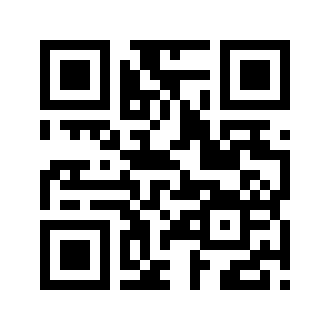

In [ ]:
qr_code = generate_qr_code(base32secret)
assert type(qr_code) == qrcode.image.pil.PilImage
qr_code

In [ ]:
uri = generate_mfa_provisioning_url(base32secret, "test_user")

qr = qrcode.QRCode()
qr.add_data(uri)
qr.print_ascii(invert=True)

█████████████████████████████████████████████
█████████████████████████████████████████████
████ ▄▄▄▄▄ █  ▄▀█▀█▀███▄█▄ ▄▄█▀█▀█ ▄▄▄▄▄ ████
████ █   █ █▀ ▄██▄▀ ▀▀▄ ▀█▀█   ▄▄█ █   █ ████
████ █▄▄▄█ ██▄▀█ █▀ █▀█ ▀▄ █▄  ▄▄█ █▄▄▄█ ████
████▄▄▄▄▄▄▄█ ▀▄█ ▀▄█▄▀▄▀▄▀ ▀ ▀▄▀ █▄▄▄▄▄▄▄████
████▄█▄▄▀ ▄▄█ ▀▄▄▀▄▀ ██▀▄  ▀ ▀█ █▀ ▀▀ ▀ ▄████
████▄ █▀ ▄▄▀    ██▀ █▄   ▄█ ▄▀ █▄▀ ▀▄▄▀██████
████▀█▀██▀▄██▀██▄▀ ██ █▀ ▀ █▀▄▄▀█▀ █ █▄  ████
██████  ▀█▄▄██ ▄▀▀▄▀█▄▄ ██ ▀▀▀▄▀▄▄█▄ █▄█▀████
█████▀▄ █▀▄▀█ ▀██▀▄█ █▀██▄██▄  ▀▄▀▄▄██   ████
██████▄▀██▄█▄▀▄ █ █▄▄  ▄▀▄▄▄▀▄▀▀▄▄▀▄█ ▄▄ ████
█████ ▄▄▀▄▄▀▄▀▀▄▀▀ █▄▄▄  █▀▀ █ █▀ ██▄▀█  ████
████▀ ▀ █ ▄  ▄▀█▀▄▄█▄ █▀▀ ▀▄▄▀▀██▄ ▀  ▀▄█████
█████▄  █ ▄ █▀  █▄▄█▀  ▀ ▀▀ ▄▄ ▄▄▀▄▀ ▀▄▀ ████
████▀▄ █ ▄▄▀▀▄█ ▀█ ▄ ▄▀▀▀ ▀▀▀▄▄▄▄▄▀ ▀ ▀▄▀████
███████▄██▄█ ██▄▀ █  █▄▄ ▄▄▀▀ ▄  ▄▄▄ ▀▀ ▄████
████ ▄▄▄▄▄ █ ▄ ▄▄▄ ▄▀██▀ ▀█▀█▄█▀ █▄█ ▀█▄▀████
████ █   █ █▀ █▀██▀▀▄█▀▄▄  ▀▄  █   ▄ ▄▀██████
████ █▄▄▄█ █▄ ▄▀▀█▀█▀▄ ▀██▄▄▄ █▄ ▄▄ ▄▀▄▄█████
████▄▄▄▄▄▄▄█▄▄▄█▄██▄▄▄█▄▄█▄▄▄▄▄▄▄█▄▄███▄▄████
██████████████████████████████████

In [ ]:
#| export


def validate_otp(mfa_secret: str, user_otp: str):
    """Validate the user OTP against the valid OTP

    Args:
        mfa_secret: The 16 character base32 secret string assigned to the user
        user_otp: OTP passed by the user

    Raises:
        HTTPError: If the user OTP is not matching with the actual OTP
    """
    totp = pyotp.TOTP(mfa_secret)

    if not totp.verify(otp=user_otp):
        raise HTTPException(
            status_code=status.HTTP_400_BAD_REQUEST,
            detail=ERRORS["INVALID_OTP"],
        )

In [ ]:
# Verifying by passing the random TOTP
random_str = "123123"
with pytest.raises(HTTPException) as e:
    validate_otp(base32secret, random_str)

random_str = ""
with pytest.raises(HTTPException) as e:
    validate_otp(base32secret, random_str)

# Verifying by passing the actual TOTP
totp = pyotp.TOTP(base32secret).now()
validate_otp(base32secret, totp)

In [ ]:
#| exporti


def get_otp(xs: Dict[str, Any]) -> Union[str, None]:
    """Get otp from the input dictionary

    Args:
        xs: Input dictionary

    Returns:
        The otp if present in input dictionary else None
    """
    if "otp" in xs:
        otp = xs["otp"]
    else:
        otp = next((getattr(v, "otp") for v in xs.values() if hasattr(v, "otp")), None)
    return otp

In [ ]:
kwargs = {
    "otp": "123456",
    "user": "user",
    "session": "session",
    "random": "asd",
    "random_": "asd",
}
expected = "123456"
actual = get_otp(kwargs)
print(actual)
assert actual == expected


class Test:
    otp = "123456"


kwargs = {
    "user": "user",
    "session": "session",
    "random": "asd",
    "random_": "asd",
    "d": Test,
}
expected = "123456"
actual = get_otp(kwargs)
print(actual)
assert actual == expected

kwargs = {
    "user": "user_value",
    "session": "session_value",
    "random": "asd",
    "random_": "asd",
}
expected = None
actual = get_otp(kwargs)
display(actual)
assert actual == expected

123456
123456


None

In [ ]:
#| export


def require_otp_if_mfa_enabled(func):
    """A decorator function to validate the otp for MFA enabled user

    If the otp validation fails, the user will not be granted access to the decorated routes
    """

    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        user = kwargs["user"]
        session = kwargs["session"]
        otp = get_otp(kwargs)

        if not user.is_mfa_active and otp is not None:
            raise HTTPException(
                status_code=status.HTTP_400_BAD_REQUEST,
                detail=ERRORS["MFA_NOT_ACTIVATED_BUT_PASSES_OTP"],
            )

        if user.is_mfa_active:
            if otp is not None:
                validate_otp(user.mfa_secret, otp)
            else:
                raise HTTPException(
                    status_code=status.HTTP_400_BAD_REQUEST,
                    detail=ERRORS["OTP_REQUIRED"],
                )

        # Do something before
        return func(*args, **kwargs)
        # Do something after

    return wrapper

In [ ]:
@require_otp_if_mfa_enabled
def test_require_otp_if_mfa_enabled(
    otp,
    user,
    session,
):
    return "Ok"


with get_session_with_context() as session:
    test_user = create_user_for_testing()
    user = session.exec(select(User).where(User.username == test_user)).one()
    with pytest.raises(HTTPException) as e:
        random_otp = "123123"
        test_require_otp_if_mfa_enabled(otp=random_otp, user=user, session=session)
    print(e.value.detail)
    assert (
        e.value.detail
        == "MFA is not activated for the account. Please pass the OTP only after activating the MFA for your account."
    )

    actual = test_require_otp_if_mfa_enabled(otp=None, user=user, session=session)
    assert actual == "Ok"
    display(actual)

MFA is not activated for the account. Please pass the OTP only after activating the MFA for your account.


/root/.local/lib/python3.8/site-packages/sqlmodel/orm/session.py:60: SAWarning: Class SelectOfScalar will not make use of SQL compilation caching as it does not set the 'inherit_cache' attribute to ``True``.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  Set this attribute to True if this object can make use of the cache key generated by the superclass.  Alternatively, this attribute may be set to False which will disable this warning. (Background on this error at: https://sqlalche.me/e/14/cprf)
  results = super().execute(


'Ok'

In [ ]:
# Context manager to create MFA enabled user
@contextmanager
def create_mfa_enabled_user():
    with get_session_with_context() as session:
        mfa_enabled_user = create_user_for_testing()
        user = session.exec(select(User).where(User.username == mfa_enabled_user)).one()
        try:
            # generate MFA
            actual = generate_mfa_url(user=user, session=session)
            assert user.mfa_secret is not None
            # activate MFA
            activate_mfa_request = ActivateMFARequest(
                user_otp=pyotp.TOTP(user.mfa_secret).now()
            )
            actual = activate_mfa(
                activate_mfa_request=activate_mfa_request, user=user, session=session
            )
            yield user, session
        finally:
            # deactivate MFA
            user = disable_mfa(
                user_uuid_or_name=str(user.uuid),
                otp=pyotp.TOTP(user.mfa_secret).now(),
                user=user,
                session=session,
            )
            assert user.mfa_secret is None


with create_mfa_enabled_user() as user_and_session:
    display(user_and_session[0])
    display(user_and_session[1])

User(id=948, uuid=UUID('7e4ce8cb-13f3-470a-bcdd-963daba627bf'), username='giskbmeuah', first_name='unittest', last_name='user', email='giskbmeuah@email.com', subscription_type=<SubscriptionType.test: 'test'>, super_user=False, disabled=False, created=datetime.datetime(2022, 8, 22, 9, 5, 15), mfa_secret=**********************************, is_mfa_active=True)

In [ ]:
with create_mfa_enabled_user() as user_and_session:
    user = user_and_session[0]
    session = user_and_session[1]
    with pytest.raises(HTTPException) as e:
        random_otp = "123123"
        test_require_otp_if_mfa_enabled(otp=random_otp, user=user, session=session)
    print(e.value.detail)
    assert e.value.detail == "Invalid OTP"

Invalid OTP


In [ ]:
with create_mfa_enabled_user() as user_and_session:
    user = user_and_session[0]
    session = user_and_session[1]
    with pytest.raises(HTTPException) as e:
        test_require_otp_if_mfa_enabled(otp=None, user=user, session=session)
    print(e.value.detail)
    assert e.value.detail == "OTP is required"

OTP is required


In [ ]:
with create_mfa_enabled_user() as user_and_session:
    user = user_and_session[0]
    session = user_and_session[1]
    valid_otp = pyotp.TOTP(user.mfa_secret).now()
    actual = test_require_otp_if_mfa_enabled(otp=valid_otp, user=user, session=session)
assert actual == "Ok"
actual

'Ok'